<a href="https://colab.research.google.com/github/dpatt830/Restaurant-DataFrame-Project2/blob/main/Copy_of_Chicago_Restaurant_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load modules
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import chi2_contingency

# Install the gmaps package (-q to do so quitely)
%pip install -q gmaps  

import gmaps
# Enter Google maps API key to be able to see heat map
gmaps.configure(api_key='')
from google.colab import output
output.enable_custom_widget_manager()

# Bring the data into a dataframe using attached data
food_inspections_df = pd.read_csv('Food_Inspections.csv')

# Making a copy of the original dataframe just in case
backup_df = food_inspections_df.copy(deep=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.7 MB/s eta 0:00:00


In [ ]:
# Looking at the original dataframe for reference
#backup_df.head(100)

In [ ]:
# Drop rows with NaN as facility type or zip codes
food_inspections_df = food_inspections_df.dropna(
    subset=['Facility Type', 'Zip'])
# lowecase facility type and results -- simplifies searching
food_inspections_df['Facility Type'] = food_inspections_df[
                                                           'Facility Type'
                                                           ].str.lower()
food_inspections_df['Results'] = food_inspections_df['Results'].str.lower()
# condition to find rows whose facility type contains "restaur"
restaurants_only = (food_inspections_df['Facility Type'].str.contains("rest"))
# conditions for failed or passed inspections
failed_inspection = (food_inspections_df['Results'] == 'fail')
passed_inspection = (food_inspections_df['Results'] == 'pass')
# apply condition to create restaurants-only df
restaurants_only_df = food_inspections_df[
                                          restaurants_only & 
                                          (failed_inspection | 
                                           passed_inspection)
                                          ]
# drop unnecessary columns
restaurants_only_df = restaurants_only_df.drop(columns=['Inspection ID', 
                                                        'AKA Name', 'Location',  
                                                        'Risk', 
                                                        'Facility Type', 
                                                        'Violations'])
# create df only with restaurants that failed
failed_restaurants_df = restaurants_only_df[
                                            (restaurants_only_df['Results']
                                             =='fail')]
# Aggregate by counting how many inspections a restaurant has failed.
failed_counts_df = failed_restaurants_df[
                                         ['License #','Results']
                                         ].groupby(by=['License #']).count()
# Reset index 
failed_counts_df = failed_counts_df.reset_index()
# Flag records with 5 or more failed inspections and less than 55
more_than_5 = failed_counts_df[
                               (failed_counts_df['Results'] > 4) & 
                               (failed_counts_df['Results'] < 55)]
more_than_5 = more_than_5.reset_index()
# Obtain the info of the restaurants with 5 or more failed inspections
multi_fails_df = failed_restaurants_df[
                                         failed_restaurants_df['License #'].
                                         isin(more_than_5['License #'])
                                         ]
# Drop any records with missing data (there may be few no more than 4-5)
multi_fails_df = multi_fails_df.dropna()
# Aggregate by restaurant information
multi_fails_df = multi_fails_df.groupby(['License #', 'DBA Name', 'Address', 
                                             'City', 'State', 'Latitude',
                                             'Longitude', 'Zip']
                                        ).count()
# And reset index (to avoid dealing with multilevel index)
multi_fails_df = multi_fails_df.reset_index()
# Set up lists with locations of these restaurants
locations = multi_fails_df[['Latitude', 'Longitude']]
# Use number of failed inspections (aggregated in Results column) as
# weights for a heat map
weights = multi_fails_df['Results']

<ipython-input-3-442fbe620abb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_inspections_df['Facility Type'] = food_inspections_df[


In [ ]:
# Produce a heat map
fig = gmaps.figure(layout={'width': '600px', 'height': '600px'})
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

Figure(layout=FigureLayout(height='600px', width='600px'))

**As we can see from the heat map above, the two most concentrated areas/neighborhoods for multiple failed inspections are Chinatown and Little India.**

In [ ]:
# Condition to find the restaurants that are neither on Devon nor on Cermak
not_devon_nor_cermak = (
    (restaurants_only_df['Zip'] != 60608.0) # Cermak zip code
    &
    (restaurants_only_df['Zip'] != 60659.0) # Devon zip code
)

# New dataframe with restaurants neither on Devon nor in Chinatown
outside_devon_cermak_df = restaurants_only_df[not_devon_nor_cermak]

**What is the percentage of failed restaurants on Devon and Cermak?**

In [ ]:
## DEVON ##

# Condition of restaurants in Devon Zip 
devon_condition = (restaurants_only_df['Zip'] == 60659.0)
# New Data frame consisting of only restaurants
# on Devon
devon_df = restaurants_only_df[devon_condition]
# Condition of Devon rest. that failed their inspection
devon_fail_inspection = (devon_df['Results'] == 'fail')
# Condition of Devon rest. that passed their inspection
devon_pass_inspection = (devon_df['Results'] == 'pass')
# New dataframes for rest. that passed and failed their
# inspection respectively
devon_pass_inspection_df = devon_df[devon_pass_inspection]
devon_fail_inspection_df = devon_df[devon_fail_inspection]
# percentage of failed Devon rest. over all Devon rest.
percent_devon = (devon_fail_inspection_df['Results'].count()
                 /
                 devon_df['Results'].count())*100
print(f"Inspections on Devon: {devon_df['Results'].count()}")
print(f"Number of failed inspections on Devon: {devon_fail_inspection_df['Results'].count()}") 
print(f"Percentage of failed inspections: {percent_devon} %")

print()

## CERMAK ##


cermak_condition = (restaurants_only_df['Zip'] == 60608.0)
# New Data frame consisting of only restaurants
# on Cermak
cermak_df = restaurants_only_df[cermak_condition]
# Cermak rest. that failed their inspection
cermak_fail_inspection = (cermak_df['Results'] == 'fail')
# Cermak rest. that passed theri inspection
cermak_pass_inspection = (cermak_df['Results'] == 'pass')
# New dataframes for rest. that passed and failed their
# inspection respectively
cermak_pass_inspection_df = cermak_df[cermak_pass_inspection]
cermak_fail_inspection_df = cermak_df[cermak_fail_inspection]
# percentage of failed Cermak rest. over all Cermak rest.
percent_cermak = (cermak_fail_inspection_df['Results'].count()
                  /
                  cermak_df['Results'].count())*100
print(f"Inspections on Cermak: {cermak_df['Results'].count()}")
print(f"Failed Inspections on Cermak: {cermak_fail_inspection_df['Results'].count()}")
print(f"Percentage of failed inspections: {percent_cermak} %")

Inspections on Devon: 2431
Number of failed inspections on Devon: 781
Percentage of failed inspections: 32.126696832579185 %

Inspections on Cermak: 2783
Failed Inspections on Cermak: 745
Percentage of failed inspections: 26.769673014732305 %


**Removing duplicated restaurants**

In [ ]:
## DEVON ##

# Using nunique function on License # to remove any duplicates
# and to give back the total number of unique rest.
total_no_dupe_devon = devon_df[['License #']].nunique()[0]
# Create a new df of only failed rest.
total_failed_devon_df = devon_df[devon_df['Results'] == 'fail']
# Apply the nunique function to the failed rest. df
# in order to get number of failed rest.
total_no_dupe_failed_devon = total_failed_devon_df[['License #']].nunique()[0]
print(f"Inspected restaurants in Devon: {total_no_dupe_devon}")
print(f"Restaurants that failed an inspection: {total_no_dupe_failed_devon}")
print(f"Percentage of failed: {100*total_no_dupe_failed_devon/total_no_dupe_devon}%")



print()

## CERMAK ##

# Using nunique function on License # to remove any duplicates
# and to give back the total number of unique rest.
total_no_dupe_cermak = cermak_df[['License #']].nunique()[0]
# Create a new df of only failed rest.
total_failed_cermak_df = cermak_df[cermak_df['Results'] == 'fail']
# Apply the nunique function to the failed rest. df
# in order to get number of failed rest.
total_no_dupe_failed_cermak = total_failed_cermak_df[['License #']].nunique()[0]
print(f"Inspected restaurants in Chinatown: {total_no_dupe_cermak}")
print(f"Restaurants that failed an inspection: {total_no_dupe_failed_cermak}")
print(f"Percentage of failed: {100*total_no_dupe_failed_cermak/total_no_dupe_cermak}%")


Inspected restaurants in Devon: 390
Restaurants that failed an inspection: 307
Percentage of failed: 78.71794871794872%

Inspected restaurants in Chinatown: 547
Restaurants that failed an inspection: 354
Percentage of failed: 64.71663619744058%


This is for removing duplicated restaurants within the dataframe. Keep in mind that restaurants can and most likely have received multiple Inspections throughout this whole time frame, but this represents restaurants that have received at least one in the entire time frame.

**What is the most common inspection type for all restaurants of each neighborhood?**

In [ ]:
## DEVON ##

# I previously included 'Inpsection Type' back into the restaurant_only_df
# to be able to use the cleaner df. Group Inspection Types with DBA Names in 
# order to have a column of the # of Inspec. Types
inspection_count_devon_df = devon_df[['DBA Name', 'Inspection Type']].groupby(by=['Inspection Type']).count()
# The most frequent inspection
most_frequent_inspection = inspection_count_devon_df['DBA Name'].max()
# Condition of which inspection type is the most frequent
most_frequent_inspection_condition = inspection_count_devon_df['DBA Name'] == most_frequent_inspection
# Display frame to show the most frequent Inspection Type
most_frequent_inspection_type = inspection_count_devon_df[most_frequent_inspection_condition]
most_frequent_inspection_type


,DBA Name
Inspection Type,
Canvass,1059


In [ ]:
## CERMAK ##

# Same as above
inspection_count_cermak_df = cermak_df[['DBA Name', 'Inspection Type']].groupby(by=['Inspection Type']).count()
# The most frequent inspection
most_frequent_inspection_cermak = inspection_count_cermak_df['DBA Name'].max()
# Condition of which inspection type is the most frequent
most_frequent_inspection_cermak_condition = inspection_count_cermak_df['DBA Name'] == most_frequent_inspection_cermak
# Display frame to show the most frequent Inspection Type
most_frequent_inspection_type_cermak = inspection_count_cermak_df[most_frequent_inspection_cermak_condition]
most_frequent_inspection_type_cermak

,DBA Name
Inspection Type,
Canvass,1205


**What is the most common Inspection type for failed restaurants in both neighborhoods?**

In [ ]:
## DEVON ##

# Same principle as above code but using the df
# with only failed inspections
fail_inspection_count_devon_df = devon_fail_inspection_df[['DBA Name', 'Inspection Type']].groupby(by=['Inspection Type']).count()
# The most frequent inspection
most_frequent_fail_inspection_devon = fail_inspection_count_devon_df['DBA Name'].max()
# Condition of which inspection type is the most frequent
most_frequent_fail_inspection_devon_condition = fail_inspection_count_devon_df['DBA Name'] == most_frequent_fail_inspection_devon
# Display frame to show the most frequent Inspection Type
most_frequent_fail_inspection_type_devon = fail_inspection_count_devon_df[most_frequent_fail_inspection_devon_condition]
most_frequent_fail_inspection_type_devon

,DBA Name
Inspection Type,
Canvass,361


In [ ]:
## CERMAK ##

# Same as above for Cermak/Chinatown df
fail_inspection_count_cermak_df = cermak_fail_inspection_df[['DBA Name', 'Inspection Type']].groupby(by=['Inspection Type']).count()
# The most frequent inspection
most_frequent_fail_inspection_cermak = fail_inspection_count_cermak_df['DBA Name'].max()
# Condition of which inspection type is the most frequent
most_frequent_fail_inspection_cermak_condition = fail_inspection_count_cermak_df['DBA Name'] == most_frequent_fail_inspection_cermak
# Display frame to show the most frequent Inspection Type
most_frequent_fail_inspection_type_cermak = fail_inspection_count_cermak_df[most_frequent_fail_inspection_cermak_condition]
most_frequent_fail_inspection_type_cermak

,DBA Name
Inspection Type,
Canvass,335


As we can see from four previous code cells, the most frequent type of Inspection Type is the "Canvass" inspection. This is just a common day-to-day restaurant inspection done on a random basis.

**What are the restaurants with the most failed inspections for each neighborhood?**

In [ ]:
## DEVON ##

# Using a df with only unique License #'s (No repeats) and failed inspection 
# within Devon, group the restaurants by name, License #, and how many failed 
# inspections they have
restaurant_by_fails_devon = total_failed_devon_df[['DBA Name', 'License #', 
                                                 'Results']].groupby(by=['License #',
                                                                           'DBA Name']).count()
# The most amount of 'fail' per one restaurant
most_failed_devon = restaurant_by_fails_devon['Results'].max()
# Condition of which restaurant has the most fails
most_failed_condition_devon = restaurant_by_fails_devon['Results'] == most_failed_devon
# Display which restaurant corresponds to the condition
most_failed_restaurant_devon = restaurant_by_fails_devon[most_failed_condition_devon]
most_failed_restaurant_devon

,,Results
License #,DBA Name,
2510903.0,"NEW HONG KONG BUFFET, INC",16


In [ ]:
## CERMAK ## 

# Same as above
restaurant_by_fails_cermak = total_failed_cermak_df[['DBA Name', 'License #', 
                                                 'Results']].groupby(by=['License #',
                                                                           'DBA Name']).count()
most_failed_cermak = restaurant_by_fails_cermak['Results'].max()
most_failed_condition_cermak = restaurant_by_fails_cermak['Results'] == most_failed_cermak
most_failed_restaurant_cermak = restaurant_by_fails_cermak[most_failed_condition_cermak]
most_failed_restaurant_cermak

,,Results
License #,DBA Name,
1893655.0,MARISCOS LAS ISLITAS,16


**Inversely, what are the restaurants with the most passed inspections?**

In [ ]:
## DEVON ##

# Nearly identical approach to above codes, only difference is we are 
# looking at restaurants that passed inspections 
# Create a new df of only passed rest. in Devon using the only unique restaurant
# df for Devon
total_passed_devon_df = devon_df[devon_df['Results'] == 'pass']
restaurant_by_passes_devon = total_passed_devon_df[['DBA Name', 'License #', 
                                                 'Results']].groupby(by=['License #',
                                                                           'DBA Name']).count()
# The most amount of 'pass' per one restaurant
most_passed_devon = restaurant_by_passes_devon['Results'].max()
# Condition of which restaurant has the most passes
most_passed_condition_devon = restaurant_by_passes_devon['Results'] == most_passed_devon
# Display which restaurant corresponds to the condition
most_passed_restaurant_devon = restaurant_by_passes_devon[most_passed_condition_devon]
most_passed_restaurant_devon

,,Results
License #,DBA Name,
1273946.0,HONG KONG BUFFET CORPORATION,21


In [ ]:
## CERMAK ##

# Same as code above, but for Cermak
# Create a new df of only passed rest. in Chinantown using only unique restaurants
# for Cermak
total_passed_cermak_df = cermak_df[cermak_df['Results'] == 'pass']
restaurant_by_passes_cermak = total_passed_cermak_df[['DBA Name', 'License #', 
                                                 'Results']].groupby(by=['License #',
                                                                           'DBA Name']).count()
# The most amount of 'pass' per one restaurant
most_passed_cermak = restaurant_by_passes_cermak['Results'].max()
# Condition of which restaurant has the most passes
most_passed_condition_cermak = restaurant_by_passes_cermak['Results'] == most_passed_cermak
# Display which restaurant corresponds to the condition
most_passed_restaurant_cermak = restaurant_by_passes_cermak[most_passed_condition_cermak]
most_passed_restaurant_cermak

,,Results
License #,DBA Name,
1332927.0,MCDONALD'S,18


**How many restaurants are contained within Chicago, outside Devon and Cermak?**

In [ ]:
# Using the df with restaurants outside Devon and Chinatown,
# find the number of unique restaurants there are

# Find the number of failed restaurants outside Devon and Chinatown
failed_outside_towns_df = outside_devon_cermak_df[outside_devon_cermak_df['Results'] == 'fail']

# Finding the numbers of restaurants, inspections, and failed inspections
number_of_restaurants_across_city = outside_devon_cermak_df[['License #']].nunique()[0]
number_of_inspections_across_city = outside_devon_cermak_df['Results'].count()
number_of_fail_across_city = failed_outside_towns_df['Results'].count()

print(f'There were {number_of_restaurants_across_city} inspected restauraunts across the city.')
print(f'There are {number_of_inspections_across_city} inspections across the city.')
print(f'There were {number_of_fail_across_city} failed inspections across the city.')

There were 20494 inspected restauraunts across the city.
There are 110060 inspections across the city.
There were 29410 failed inspections across the city.


**How do failed restaurants in Devon and Cermak compare to the rest of the city?**

In [ ]:
## DEVON ##

# Using our known numbers and percentages, compare failed inspections on Devon
# to the rest of the city
print(f'Percentage of restaurants that failed an inspection in Devon: {percent_devon} %')

# Trying to save some space below by not using format string
print('Percnetage of restaurants that failed an inpsection across the city:',
                               100*number_of_fail_across_city/
                              number_of_inspections_across_city, '%')
                                                                          

print()


## Cermak ##

# Similar to above but restaurants in Chinatown
# Print statements to compare the percentages of failed restaurants across Chicago
# vs ones in Chinatown
print('Percentage of restaurants that failed an inspection in Chinatown:', 
                               percent_cermak, '%')
print('Percnetage of restaurants that failed an inpsection across the city:',
                               100*number_of_fail_across_city/
                              number_of_inspections_across_city, '%')

Percentage of restaurants that failed an inspection in Devon: 32.126696832579185 %
Percnetage of restaurants that failed an inpsection across the city: 26.721788115573325 %

Percentage of restaurants that failed an inspection in Chinatown: 26.769673014732305 %
Percnetage of restaurants that failed an inpsection across the city: 26.721788115573325 %


**Is this data statistically significant?**

Performing a Chi-Square test to test if there is a significant relationship between inspection result and location in city.

In [ ]:
## Chi - Square test ##

import numpy as np
from scipy.stats import chi2_contingency
 

passed_outside_towns_df = outside_devon_cermak_df[outside_devon_cermak_df['Results'] == 'pass']

frames1 = [total_passed_cermak_df, total_failed_cermak_df] 
frames2 = [total_passed_devon_df, total_failed_devon_df]
frames3 = [passed_outside_towns_df, failed_outside_towns_df]
result1 = pd.concat(frames1, keys=["Passed", "Failed"])
result2 = pd.concat(frames2, keys=["Passed", "Failed"])
result3 = pd.concat(frames3, keys=["Passed", "Failed"])

all_frames = [result1, result2, result3]



In [ ]:
## Getting Raw data for new dataframes to create cotingency table

total_failed_devon = devon_fail_inspection_df['Results'].count()

total_failed_cermak = cermak_fail_inspection_df['Results'].count()

total_passed_cermak = cermak_df['Results'].count() - total_failed_cermak

total_passed_devon = devon_df['Results'].count() - total_failed_devon

passed_outside_towns_number =  (number_of_inspections_across_city) - number_of_fail_across_city

# Creating new df/table just for a visual aid for our contingency table
# we are performing our Chi-Squared Test on and to perform the Chi-Squared Test

d = {"Devon": [total_failed_devon, total_passed_devon],
     "Cermak": [total_failed_cermak, total_passed_cermak],
     "Rest of city": [number_of_fail_across_city, passed_outside_towns_number]}

table_df = pd.DataFrame(data=d, index=['Failed', 'Passed'])



# Statistical variables using the Chi-Square test
c, p, dof, expected = chi2_contingency(table_df)
print(f'Chi-Squared = {c}')
print(f'Resulting p-value = {p}')

Chi-Squared = 35.39397230491876
Resulting p-value = 2.062037540903855e-08


**From the above test statistics, assuming  a level of significance of 0.05, we reject the null hypothesis. There is evidence of a significant relationship of inspection result and location of restaurant.**

In [ ]:
# New Table with totals

new_table_df = table_df.copy(deep=True)              # Copy of table_df
new_table_df.loc['Total'] = new_table_df.sum()       # Column totals
new_table_df['Total'] = new_table_df.sum(axis=1)     # Row totals


new_table_df

,Devon,Cermak,Rest of city,Total
Failed,781,745,29410,30936
Passed,1650,2038,80650,84338
Total,2431,2783,110060,115274


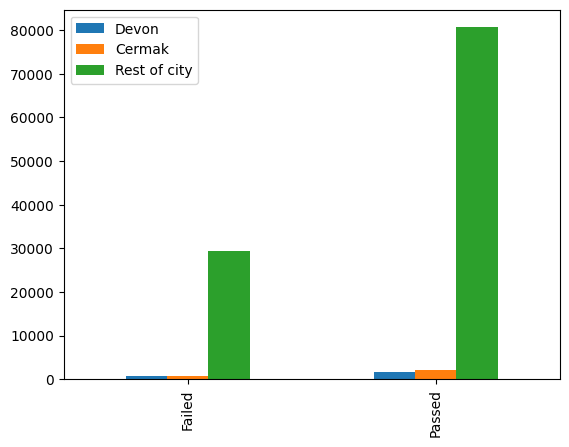

In [ ]:
# Creating a bar graph of the above contingency table
table_df.plot(kind='bar')

plt.show()

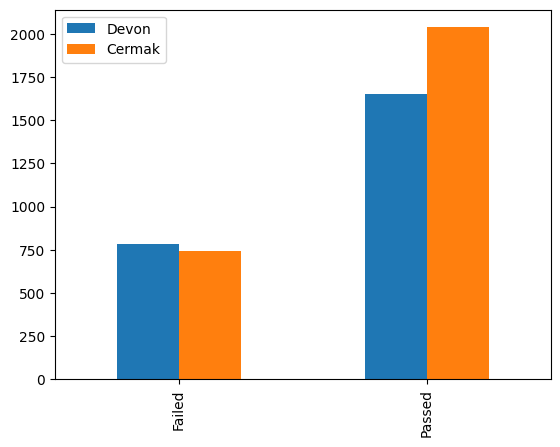

In [ ]:
# Creating a bar graph of only Devon and Cermak
bar_table_df = table_df.drop(columns=['Rest of city'])
bar_table_df.plot(kind='bar')

plt.show()

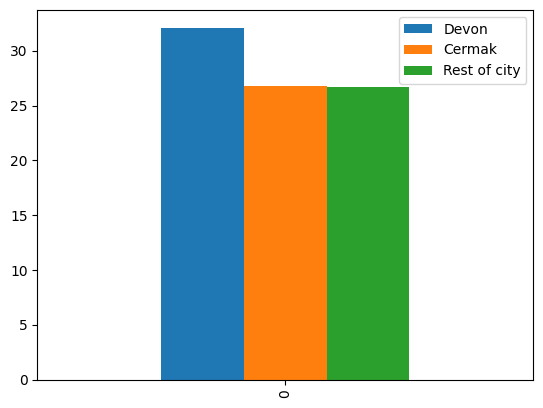

In [ ]:
# Creating a bar graph using the percentages of failures across
# the three different locations

# First creating a new dataframe with our current percentage variables
percent = {"Devon": [percent_devon],
     "Cermak": [percent_cermak],
     "Rest of city": [100*number_of_fail_across_city/number_of_inspections_across_city]}

percent_df = pd.DataFrame(data=percent)

#Creating bar graph
percent_df.plot(kind='bar')

plt.show()